### Importing required modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import re
from sklearn.cluster import MiniBatchKMeans

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
# tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle
import gzip

In [2]:
# Loading data
data = pd.read_csv('/content/drive/MyDrive/ML Datasets/text semantics data/Text_Similarity_Dataset.csv')

#### Data Cleaning


In [3]:
# remove stopwords 
# (Stopwords are the English words which does not add much meaning to a sentence. 
# They can safely be ignored without sacrificing the meaning of the sentence.
# For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.

stop = set(stopwords.words("english"))

# This function removes stopwords
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

temp = pd.DataFrame({'text1':data.text1.map(remove_stopwords),'text2':data.text2.map(remove_stopwords)})

# # remove spaces, punctuations and numbers
# clean_text = re.sub('[^a-zA-Z]', ' ', article_text)
# clean_text = re.sub('\s+', ' ', clean_text)
# clean_text

def remove_numbers_and_punctuations(text):
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub('\s+', ' ', text)
  return text

temp.text1 = temp.text1.map(remove_numbers_and_punctuations)
temp.text2 = temp.text2.map(remove_numbers_and_punctuations)

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
# Stemming removes unnecessary endings of words like "genoursly" to "genorous"
def applying_stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return " ".join(stemmed_words)

# Applying stemming
temp.text1 = temp.text1.map(applying_stemming)
temp.text2 = temp.text2.map(applying_stemming)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

# creating a list texts
token_list = []

for text in temp.text1.values:
  token_list.append(text)
for text in temp.text2.values:
  token_list.append(text)

from collections import Counter
count = Counter()
# Count unique words
def counter_word(text_col):
    
    for text in text_col.values:
        for word in text.split():
            count[word] += 1


counter_word(temp.text1)
counter_word(temp.text2)

num_unique_words = len(count)

# vectorize a text corpus by turning each text into a sequence of interger
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(token_list)  

train = tokenizer.texts_to_sequences(token_list)

# pad the sentence to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Maximum number of words in a suquence
max_length = 250
# Making each text size to be 250 words and cropping long sentences
train_padded = pad_sequences(train, maxlen=max_length, padding="post", truncating="post")


As I need to consider this problem as Unsupervised Learning. So I have used clustering methods to cluster our sentences and then label those texts based on MiniBatchKmeans. So that for further we can apply Deep Learning algorithms. I will explain more clearly in text report.

In [13]:

model_clustering = MiniBatchKMeans(n_clusters=2)
model_clustering.fit(train_padded)
# assign a cluster to each example
yhat = model_clustering.predict(train_padded)
# retrieve unique clusters
clusters = unique(yhat)


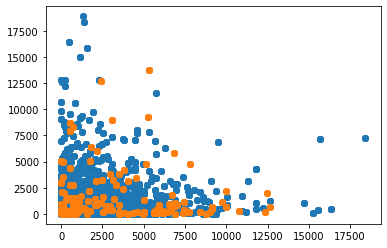

In [14]:
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(train_padded[row_ix, 0], train_padded[row_ix, 1])
# show the plot
plt.show()

In [15]:
# Finding labels of two sentences based on the cluster that both sentences resides
temp_data_labels = []
for i in range(data.shape[0]):
  if yhat[i] == yhat[data.shape[0]+i]:
    temp_data_labels.append(1)
  else:
    temp_data_labels.append(0)

Making Labelled data based on clusters

In [16]:
# Finally, we made our data into labelled data.
final_data = pd.DataFrame({'text1':temp.text1,'text2':temp.text2,'label':temp_data_labels})

In [17]:
final_data.label.value_counts()

1    3571
0     452
Name: label, dtype: int64

Char Encoder

I have used CharEncoder to encoder our paragraphs.

In [18]:
class CharEncoder(object):

  def __init__(self, *, max_length=6000, padding='end'):
    # Tokens for encoding
    self.CHARS_TOKENS = ['<PAD>', '<START>','<END>', '<UNK>']
    # list of Alphabets
    self.CHARS_ALPHA_LOWER = [chr(x) for x in range(0x0061, 0x007b)] #"abcdefghijklmnopqrstuvwxyz"
    self.CHARS_WHITESPACES = [x for x in '\t\n ']
    self.CHARS = ( self.CHARS_TOKENS 
                + self.CHARS_ALPHA_LOWER
                + self.CHARS_WHITESPACES )
    # Setting indexes to each character
    self.INDEXES = {c:i for i,c in enumerate(self.CHARS)}
    # Setting max_length of sentences
    self.MAX_LENGTH = max_length
    self.PADDING = padding
    self.LEN = len(self.CHARS)
  
  # This function helps to decode text based index values
  # If adds apdding and truncate sentence if it is large
  def text_to_idx(self, s, *, max_length=None, padding=None):
    idx_array = [self.INDEXES['<START>']]
    idx_array += [self.INDEXES[c] if c in self.CHARS else self.INDEXES['<UNK>']
                  for c in s]
    idx_array += [self.INDEXES['<END>']]

    if not max_length:
      max_length = self.MAX_LENGTH

    if not padding:
      padding = self.PADDING

    pad_size = max_length - len(idx_array)
    if 0 < pad_size and padding == 'start':
      idx_array = [self.INDEXES['<PAD>'] for _ in range(pad_size)] + idx_array
    elif 0 < pad_size and padding=='end':
      idx_array = idx_array + [self.INDEXES['<PAD>'] for _ in range(pad_size)]

    return list(idx_array[:max_length])

  # Decodes from indexs to texts
  def idx_to_text(self, idxes, *, with_token=False):
    char_list = [self.CHARS[i] for i in idxes if i < len(self.CHARS)]
    if with_token != True:
      char_list = [c for c in char_list if c not in self.CHARS_TOKENS]
    return ''.join(char_list)

  def to_idx(self, s_list, *, max_length=None, padding=None):
    return [self.text_to_idx(s, max_length=max_length, padding=padding) 
              for s in s_list]
    
  def to_text(self, idxes_list, *, with_token=False):
    return [self.idx_to_text(idxes, with_token=with_token)
              for idxes in idxes_list]

In [19]:
# Observing how CharEncoder works
enc = CharEncoder(max_length=6000, padding='end')
test = np.array(enc.to_idx(final_data.text1))
print(test.shape)
print(final_data.text1[:3])
print(test[:3])
print(enc.to_text(test)[:3])

(4023, 6000)
0    savvi searcher fail spot ad internet search en...
1    million miss net uk popul still without intern...
2    young debut cut short ginepri fifteen year old...
Name: text1, dtype: object
[[ 1 22  4 ...  0  0  0]
 [ 1 16 12 ...  0  0  0]
 [ 1 28 18 ...  0  0  0]]
['savvi searcher fail spot ad internet search engin user odd mix naiv sophist suggest report search habit report us pew research center reveal searcher usual find look use search engin also show spot differ paid for result organ one report reveal net user say regular use googl ask jeev msn yahoo onlin almost question said would trust search engin much less knew inform paid result hidden accord figur gather pew research averag user spend minut per month carri separ search look webpag hunt signific chunk net user carri search least week ask look everi week question inform look critic inform simpli find search engin user also tend loyal found site feel trust tend stick it accord pew research searcher use singl se

My approach is to build model more or like a Siamse Network.
A Siamese neural network (sometimes called a twin neural network) is an artificial neural network that contains two or more identical subnetworks which means they have the same configuration with the same parameters and weights. Usually, we only train one of the subnetworks and use the same configuration for other sub-networks. These networks are used to find the similarity of the inputs by comparing their feature vectors.

I have used Siamse Network Architecture to finding similarity between two sentences. Here is the diagram of complete architecture of Siamse Nework.

Complete Architecture
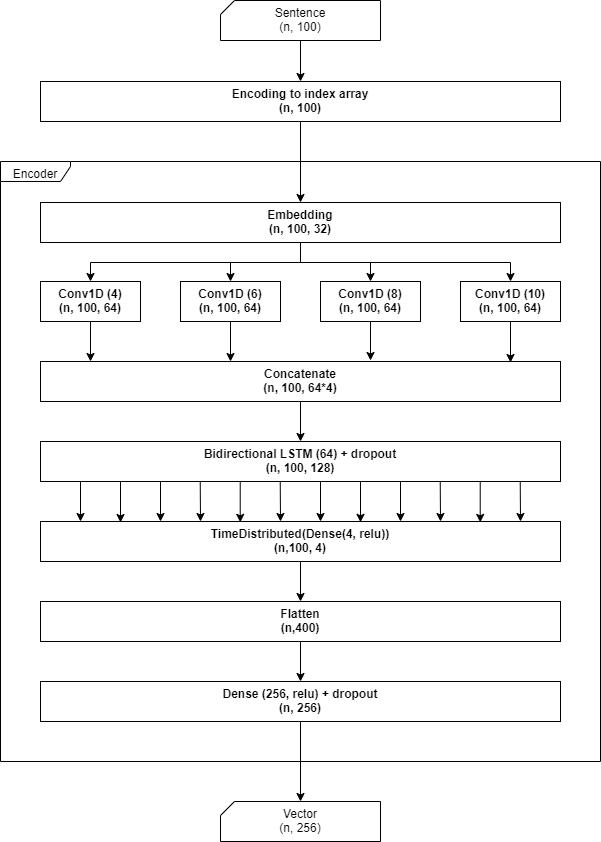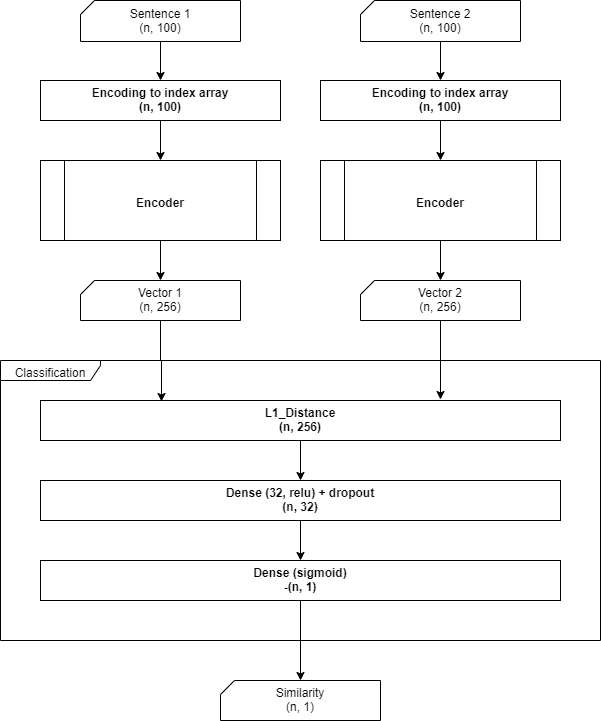

In [43]:
# Creating class Config for seeting Hyperparameters
class Config(object):

  PADDING = "end"
  
  MAX_TEXT_LEN = 100
  VECTOR_SIZE = 6000

  EMBEDDING_DIM = 32

  CONV_FILTER_NUMS = [64, 64, 64, 64] 
  CONV_FILTER_SIZES = [4, 6, 8, 10]

  LSTM_HIDDEN_NUM = 64
  LSTM_DROPOUT = 0.3

  ENC_DENSE_DROPOUT = 0.3
  ENC_DENSE_NUM = VECTOR_SIZE

  LAST_DENSE_DROPOUT = 0.3
  LAST_DENSE_NUM = 32

  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  EPOCHS = 10

  def __init__(self):
    self.ENCODER = CharEncoder(max_length=self.MAX_TEXT_LEN, padding=self.PADDING)
    self.NUM_WORDS = self.ENCODER.LEN

In [44]:
# I will explain my strategy in my report.

def _obtain_input_shape(max_text_len):
    if not (isinstance(max_text_len, int)):
        raise(ValueError('`max_text_len` should be' +
                         'a single integer.'))
    input_shape = (max_text_len, )
        
    return input_shape

# Function to build 4 convolution blocks
def _conv_block(inputs,
                filter_nums,
                filter_sizes):

    conv_blocks = []
    # Using 4,6,8,10 Conv1D to extract meaning between words    
    for fn, fs in zip(filter_nums, filter_sizes):
        conv = layers.Conv1D(filters=fn,
                             kernel_size=fs,
                             padding='same',
                             activation='relu',
                             strides=1)(inputs)

        conv_blocks.append(conv)

    return conv_blocks


# It encodes sentences to vector.Encoding and Embedding character by character
def VectEncoder(weights=None, config=None): 
    input_shape = _obtain_input_shape(config.MAX_TEXT_LEN)
    inputs = layers.Input(shape=input_shape) # Defining Inputs with shape

    x = layers.Embedding(config.NUM_WORDS, 
                         config.EMBEDDING_DIM,
                         input_length=config.MAX_TEXT_LEN)(inputs) # Defining 4 convolution blocks
    conv_blocks = _conv_block(x, config.CONV_FILTER_NUMS,
                                 config.CONV_FILTER_SIZES) #using 4,6,8,10 Conv1D to extract meaning between words
    x = layers.Concatenate()(conv_blocks) # Concatenating conv blocks
    # Adding Bidirectional LSTM to capture relationship in long sequence
    # Using Bidirectional LSTM to understand context meaning
    x = layers.Bidirectional(layers.LSTM(config.LSTM_HIDDEN_NUM, dropout=config.LSTM_DROPOUT, return_sequences=True))(x)
    # Reduces dimensions with TimeDistributed (Dense) to preserve the information of all time steps as much as possible
    x = layers.TimeDistributed(layers.Dense(4, activation='relu'))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(config.ENC_DENSE_DROPOUT)(x)
    x = layers.Dense(config.ENC_DENSE_NUM, activation='relu')(x) #Final Vector Output

    model = models.Model(inputs, x)

    if weights is not None:
        model.load_weights(weights)
 
    return model

# It combines both the vectors 
def VectSimilarityEstimator(weights=None, config=None):
  input_shape = _obtain_input_shape(config.VECTOR_SIZE)
  inputs1 = layers.Input(shape=input_shape)
  inputs2 = layers.Input(shape=input_shape)
  # layer for capturing L1 distances between two encoded vectors
  x = layers.Lambda(lambda tensors:backend.abs(tensors[0] - tensors[1]))([inputs1, inputs2]) # L1 distance
  x = layers.Dropout(config.LAST_DENSE_DROPOUT)(x)
  x = layers.Dense(config.LAST_DENSE_NUM, activation='relu')(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model([inputs1, inputs2], x)

  if weights is not None:
        model.load_weights(weights)
 
  return model

def SentenceSimilarityEstimator(weights=None, config=None):
  input_shape = _obtain_input_shape(config.MAX_TEXT_LEN)
  sent1 = layers.Input(shape=input_shape)
  sent2 = layers.Input(shape=input_shape)
  # Encoder for encoding senetence 1
  encoder_1 = VectEncoder(config=config)
  # Encoder for encoding senetence 2
  encoder_2 = VectEncoder(config=config)
  # merging both encoders
  estimator = VectSimilarityEstimator(config=config)

  vect1 = encoder_1(sent1)
  vect2 = encoder_2(sent2)
  similarity = estimator([vect1, vect2])

  model = models.Model([sent1, sent2], similarity)

  if weights is not None:
        model.load_weights(weights)

  return model, encoder_1, encoder_2, estimator


In [45]:
# Building our final model.
class MyDLModel(object):
  def __init__(self, *, config=None, load_file_prefix=None):
    if load_file_prefix:
      cf,wf = self.__get_file(load_file_prefix)
      self.config = self.__load_config(cf)
      weight_file = wf
    else:
      self.config = config if config else Config()
      weight_file = None
    
    model, encoder_1, encoder_2, estimator = SentenceSimilarityEstimator(config=self.config, weights=weight_file)
    self.model = model
    self.encoder_1 = encoder_1
    self.encoder_2 = encoder_2
    self.estimator = estimator

    self.model.compile(optimizer=keras.optimizers.Adam(self.config.LEARNING_RATE),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
  
  def __get_file(self, prefix):
    config_name = prefix+"_config.pkl"
    weight_name = prefix+"_weight.hd5"
    return config_name, weight_name

  def __load_config(self, load_file):
    with gzip.open(load_file, 'rb') as f:
      config = pickle.load(f)
    return config

  def __save_config(self, save_file):
    with gzip.open(save_file, 'wb') as f:
      config = pickle.dump(self.config, f)
    return config

  def save_model(self, file_name_prefix):
    cf,wf = self.__get_file(file_name_prefix)
    self.model.save_weights(wf)
    self.__save_config(cf)
    print(file_name_prefix,"Saved")

  def summary(self, recusive=False):
    self.model.summary()
    if recusive:
      print()
      print("== encoder_1 ==")
      self.encoder_1.summary()
      print()
      print("== encoder_2 ==")
      self.encoder_2.summary()
      print()
      print("== estimator ==")
      self.estimator.summary()

  def encodeSents(self, data_X):
    enc = self.config.ENCODER
    sents1 = np.array(enc.to_idx(data_X.text1))
    sents2 = np.array(enc.to_idx(data_X.text2))
    return [sents1, sents2]

  def makeInt(self, data_Y):
    y = np.array(data_Y.astype('int'))
    return y

  def fit(self, train_X, train_Y, *, valid=None, epochs=None, batch_size=None):
    if valid:
      validation_data = (self.encodeSents(valid[0]), self.makeInt(valid[1]))
    else:
      validation_data = None

    if not epochs:
      epochs = self.config.EPOCHS
    if not batch_size:
      batch_size = self.config.BATCH_SIZE

    history = self.model.fit(self.encodeSents(train_X), self.makeInt(train_Y),
                   epochs=epochs, batch_size=batch_size,
                   validation_data=validation_data)
    
    return history

  def evaluate(self, data_X, data_Y):
    self.model.evaluate(self.encodeSents(data_X), self.makeInt(data_Y))

  def predict_proba(self, data_X):
    y = self.model(self.encodeSents(data_X))
    y = np.array(y).reshape(-1,)
    return y
    
  def predict(self, data_X):
    return 0.5 < self.predict_proba(data_X)


In [ ]:
model = MyDLModel()
model.summary(True)

In [47]:
trainX = final_data.iloc[:,:-1]
trainY = final_data.iloc[:,-1]
model.evaluate(trainX, trainY)

126/126 [==============================] - 9s 43ms/step - loss: 0.6930 - accuracy: 0.5881


Epoch 1/10
16/16 [==============================] - 11s 171ms/step - loss: 0.3916 - accuracy: 0.8673
Epoch 2/10
16/16 [==============================] - 3s 166ms/step - loss: 0.3518 - accuracy: 0.8876
Epoch 3/10
16/16 [==============================] - 3s 168ms/step - loss: 0.3520 - accuracy: 0.8876
Epoch 4/10
16/16 [==============================] - 3s 169ms/step - loss: 0.3495 - accuracy: 0.8876
Epoch 5/10
16/16 [==============================] - 3s 166ms/step - loss: 0.3504 - accuracy: 0.8876
Epoch 6/10
16/16 [==============================] - 3s 166ms/step - loss: 0.3437 - accuracy: 0.8876
Epoch 7/10
16/16 [==============================] - 3s 168ms/step - loss: 0.3458 - accuracy: 0.8876
Epoch 8/10
16/16 [==============================] - 3s 168ms/step - loss: 0.3380 - accuracy: 0.8876
Epoch 9/10
16/16 [==============================] - 3s 166ms/step - loss: 0.3406 - accuracy: 0.8876
Epoch 10/10
16/16 [==============================] - 3s 167ms/step - loss: 0.3255 - accuracy: 0.887

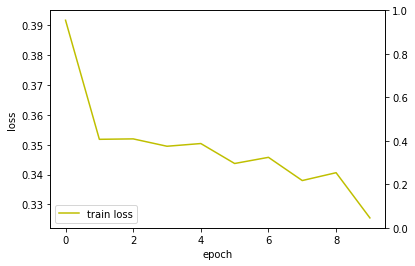

In [48]:
def show_learning_curve(hist):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  # loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='lower left')

  plt.show()

learn_hists = []
def train_and_show_for_DL(model):
  hist = model.fit(trainX, trainY, epochs=5)
  learn_hists.append(hist)
  print("== learning curve ==")
  show_learning_curve(hist)
  pred_Y = model.predict(trainX)


model = MyDLModel()
train_and_show_for_DL(model)

These are the functions that maps to updated vectors after training the Siamse Network.

In [29]:
def getVector1(model, descriptions):
  return  np.array(model.encoder_1(np.array(model.config.ENCODER.to_idx(descriptions))))

def getVector2(model, descriptions):
  return np.array(model.encoder_2(np.array(model.config.ENCODER.to_idx(descriptions))))



In [49]:
vector_x = getVector1(model, final_data.text1)
vector_y = getVector2(model, final_data.text2)

In [67]:
# Calculating the similarity between two encoded vectors
from scipy import spatial
similarity = []
for i in range(final_data.shape[0]):
  similarity.append(1-spatial.distance.cosine(vector_x[i], vector_y[i]))


In [76]:
sravan_kumar_submission = pd.DataFrame(index=final_data.index,data = {'similarity':similarity})

In [78]:
# saving the dataframe
sravan_kumar_submission.to_csv('sravan_kumar_submission.csv')

This is the end of code.
Thanks for giving me this oppourtunity.



Thanks and Regards,

Sravan Kumar (AI Enthusiast)